In [63]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

def show_images(images):
    if len(images) <= 2:
        fig, axes = plt.subplots(1, 2, figsize=(10, 10))
        for i, img in enumerate(images):
            axes[i].imshow(img, cmap="gray")
            axes[i].axis("off")
    else:
        fig, axes = plt.subplots(len(images) // 2, 2, figsize=(10, 10))
        for i, img in enumerate(images):
            axes[i // 2, i % 2].imshow(img, cmap="gray")
            axes[i // 2, i % 2].axis("off")

    plt.show()

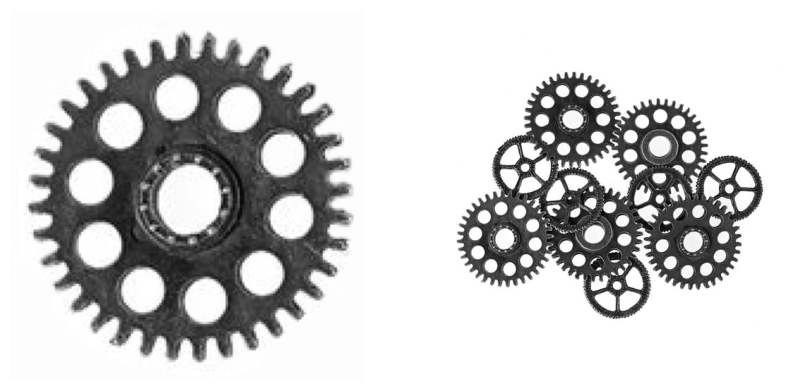

In [64]:


trybik = cv2.imread('trybik.jpg', cv2.IMREAD_GRAYSCALE)
trybiki = cv2.imread('trybiki2.jpg', cv2.IMREAD_GRAYSCALE)

show_images([trybik, trybiki])

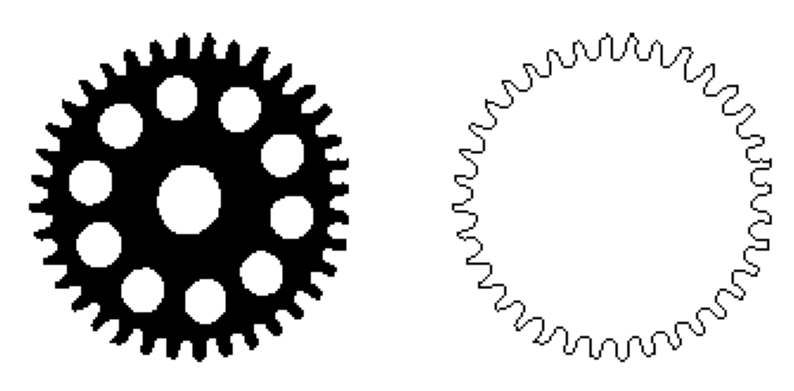

In [65]:
trybik_bin = cv2.threshold(trybik, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
trybik_closed = cv2.morphologyEx(trybik_bin[1], cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

not_trybik = cv2.bitwise_not(trybik_closed)

trybik_contours, _ = cv2.findContours(not_trybik, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

trybik_cont = cv2.drawContours(np.ones_like(trybik) * 255, trybik_contours[0], -1, (0, 0, 0), 1)

show_images([trybik_closed, trybik_cont])

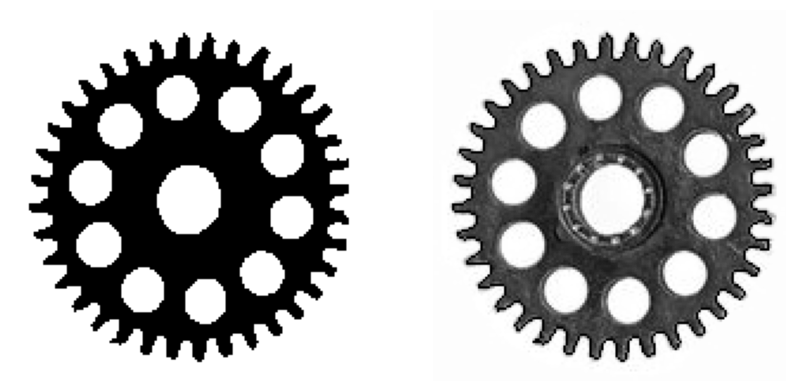

In [66]:
# draw trybiki_cont on trybiki

trybiki_bin = cv2.threshold(trybik, 150, 255, cv2.THRESH_BINARY)
trybiki_closed = cv2.morphologyEx(trybiki_bin[1], cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

not_trybiki = cv2.bitwise_not(trybiki_closed)

trybiki_contours, _ = cv2.findContours(not_trybiki, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

trybiki_cont = cv2.drawContours(trybik, trybiki_contours[0], -1, (0, 0, 0), 1)

show_images([trybiki_closed, trybiki_cont])


In [67]:
print(len(trybik_contours))

12


In [68]:
sobelx_trybik = cv2.Sobel(trybik ,cv2.CV_64F ,1,0,ksize =5)
sobely_trybik = cv2.Sobel(trybik ,cv2.CV_64F ,0,1,ksize =5)

magnitude = np.sqrt(sobelx_trybik**2 + sobely_trybik**2)
normalized_magn = magnitude / np.max(magnitude)

gradient_orient = (np.arctan2(sobely_trybik, sobelx_trybik) * (180 / np.pi) + 360) % 360 

In [69]:
m_trybik = cv2.moments(trybik_closed, 1)

trybik_referal_point = (int(m_trybik["m10"] / m_trybik["m00"]), int(m_trybik["m01"] / m_trybik["m00"]))

R_table = [[] for _ in range(360)]

for contur in trybik_contours[0:1]:
    for point in contur:
        x, y = point[0]
        vector = np.array([x - trybik_referal_point[0], y - trybik_referal_point[1]])
        length = np.linalg.norm(vector)
        angle = np.arctan2(vector[1], vector[0])
        orientation = int(gradient_orient[y, x])
        R_table[orientation].append((length, angle))


In [70]:
print(sum([len(x) for x in R_table]))
for i, x in enumerate(R_table):
    print(f"{i}: {x}")
    # print(len(x))

796
0: [(65.76473218982953, 1.4181469983996315), (65.14598989960932, 1.2587542052323633)]
1: [(68.6804193347711, -0.8368989743486738), (64.62197768561404, -1.1902899496825317), (63.071388124885914, -1.5232132235179132)]
2: [(61.29437168288782, -0.982793723247329), (60.07495318350236, -1.5208379310729538)]
3: [(64.77653896280658, 1.4157995848709557), (70.21395872616783, 1.2670618409523098)]
4: [(72.12489168102785, 0.7853981633974483), (64.47480127925948, 0.4150747336946735)]
5: [(71.02112361825881, 0.16977827396833844)]
6: [(66.75327707311455, 1.4204248987877621), (62.12889826803627, -0.9917220574271658)]
7: [(65.00769185258002, 1.5861797285754917), (72.89718787443039, 0.46978250135868205), (64.53681120105021, -1.3521273809209546)]
8: [(64.00781202322104, 1.5864200554153733), (64.41273166075166, 1.0863183977578734), (64.35060217278468, 0.5750722897323907), (62.36184731067546, -0.27609701939543646), (62.16912416947821, -0.4492601126118805), (69.42621983083913, -0.8465463260467495), (61.8

In [71]:
sobelx_trybiki = cv2.Sobel(trybiki ,cv2.CV_64F ,1,0,ksize =5)
sobely_trybiki = cv2.Sobel(trybiki ,cv2.CV_64F ,0,1,ksize =5)

magnitude = np.sqrt(sobelx_trybiki**2 + sobely_trybiki**2)
normalized_magn = magnitude / np.max(magnitude) 

gradient_orient = np.arctan2(sobely_trybiki, sobelx_trybiki) * (180 / np.pi) % 360

In [72]:
hough_space = np.zeros_like(trybiki).astype(np.float32)
for y in range(trybiki.shape[0]):
    for x in range(trybiki.shape[1]):
        if normalized_magn[y, x] > 0.5:
            orientation = int(gradient_orient[y, x])
            for r, fi in R_table[orientation]:
                x1 = int(-r * np.cos(fi) + x)
                y1 = int(-r * np.sin(fi) + y)
                if 0 <= x1 < trybiki.shape[1] and 0 <= y1 < trybiki.shape[0]:
                    hough_space[y1, x1] += 1

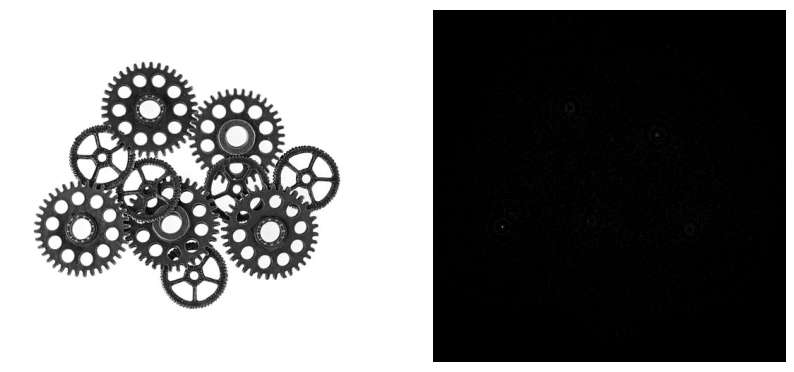

In [73]:
show_images([trybiki, hough_space])

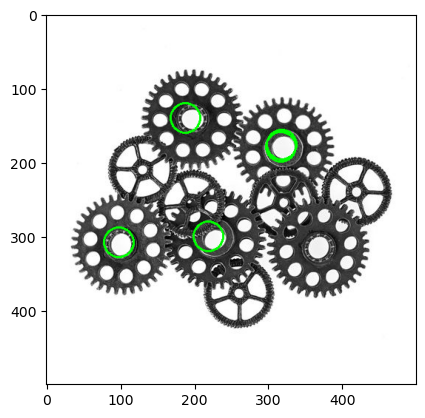

True

In [74]:
temp = []
for i in range(5):
    argmax = np.unravel_index(np.argmax(hough_space, axis=None), hough_space.shape) 
    temp.append(argmax)
    hough_space[argmax[0] - 20 : argmax[0] + 20, argmax[1] - 20 : argmax[1] + 20] = 0

import matplotlib.pyplot as plt
trybiki = cv2.cvtColor(trybiki, cv2.COLOR_GRAY2BGR)
for point in temp:
    cv2.circle(trybiki, (point[1], point[0]), 20, (0, 255, 0), 2)
#     plt.plot(point[0], point[1], '*', color='r')
plt.imshow(trybiki)
plt.show()


cv2.imwrite("trybiki.jpg", trybiki)